In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

c:\Users\c_che\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('Industry_Portfolios.csv', index_col=0)
df.index = pd.to_datetime(df.index, format='%Y%m').to_period('M')
df

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2004-01,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
2004-02,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2004-03,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
2004-04,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
2004-05,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86
...,...,...,...,...,...,...,...,...,...,...
2013-08,-4.00,-1.00,-1.95,-1.83,-0.12,-3.28,-4.21,-3.49,-4.43,-3.66
2013-09,1.94,6.46,5.20,2.03,3.77,4.33,4.46,4.19,1.05,3.83
2013-10,4.75,0.72,4.56,4.86,3.80,5.52,5.08,3.47,3.35,3.87


In [3]:
# Convert percentage returns to decimal
returns = df / 100

mean_returns = returns.mean()
cov_matrix = returns.cov()

# Show a table of mean returns and s.d.
mean_std_table = pd.DataFrame({
    'Mean Return (%)': mean_returns * 100,
    'Standard Deviation (%)': returns.std() * 100
})
round(mean_std_table,3)

,Mean Return (%),Standard Deviation (%)
NoDur,0.903,3.346
Durbl,0.733,8.362
Manuf,1.013,5.310
Enrgy,1.231,6.082
HiTec,0.766,5.381
Telcm,0.881,4.448
Shops,0.916,4.094
Hlth,0.784,3.787
Utils,0.907,3.702
Other,0.489,5.582


Plot efficient frontier using minimisation package available in Scipy.

In [4]:
# Weights must sum equal to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
# No short-selling allowed
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

def minimize_variance(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1] **2

def efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    target_returns = np.linspace(0.0, 0.02, num_portfolios)  # target returns from 0% to 2%
    frontier_std = []
    for target_return in target_returns:
        def portfolio_return_diff(weights):
            return portfolio_performance(weights, mean_returns, cov_matrix)[0] - target_return
        
        result = minimize(minimize_variance, len(mean_returns) * [1. / len(mean_returns)], args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=[constraints, {'type': 'eq', 'fun': portfolio_return_diff}])
        
        frontier_std.append(portfolio_performance(result.x, mean_returns, cov_matrix)[1])

    return target_returns, frontier_std

In [5]:
target_returns, frontier_std = efficient_frontier(mean_returns, cov_matrix)

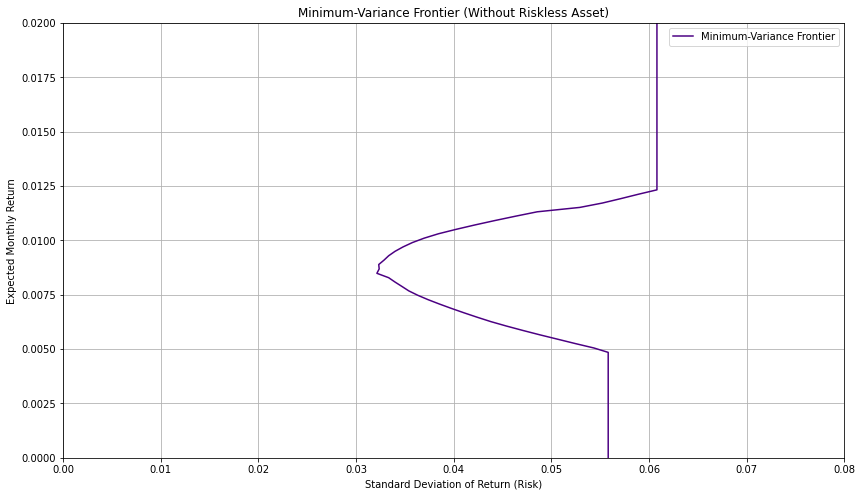

In [6]:
plt.figure(figsize=(14, 8))
plt.plot(frontier_std, target_returns, label='Minimum-Variance Frontier', color='indigo')
plt.xlabel('Standard Deviation of Return (Risk)')
plt.ylabel('Expected Monthly Return')
plt.title('Minimum-Variance Frontier (Without Riskless Asset)')
plt.xlim(0, 0.08)
plt.ylim(0, 0.02)
plt.grid(True)
plt.legend()
plt.show()

Plot efficient frontier using analytic formula instead.

In [7]:
# Plot efficient frontier using analytic formula
def analytical_efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    ones = np.ones(len(mean_returns))
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate constants
    A = ones.T @ inv_cov_matrix @ ones
    B = ones.T @ inv_cov_matrix @ mean_returns
    C = mean_returns.T @ inv_cov_matrix @ mean_returns
    Delta = A * C - B ** 2
    print(A, B, C, Delta)
    target_returns = np.linspace(0.0, 0.02, num_portfolios)

    # Calculate portfolio variances
    frontier_variances = (A * target_returns ** 2 - 2 * B * target_returns + C) / Delta
    frontier_std = np.sqrt(frontier_variances)

    return target_returns, frontier_std

1373.87597356712 13.794323869931935 0.19640858464482364 79.55766441727317


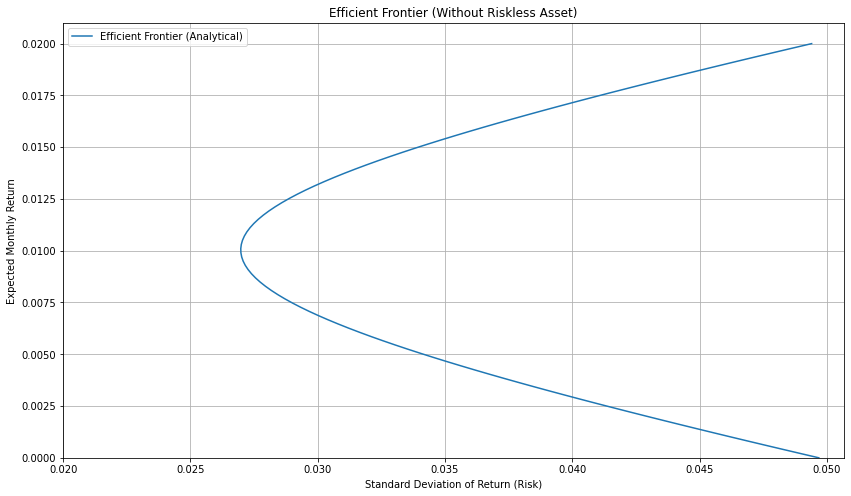

In [9]:
target_returns, frontier_std = analytical_efficient_frontier(mean_returns, cov_matrix)

plt.figure(figsize=(14, 8))
plt.plot(frontier_std, target_returns, label='Efficient Frontier (Analytical)')
plt.xlabel('Standard Deviation of Return (Risk)')
plt.ylabel('Expected Monthly Return')
plt.title('Efficient Frontier (Without Riskless Asset)')
plt.xlim(0.02, frontier_std.max() + 0.001)
plt.ylim(0, target_returns.max() + 0.001)
plt.grid(True)
plt.legend()
plt.show()

#### Part 2

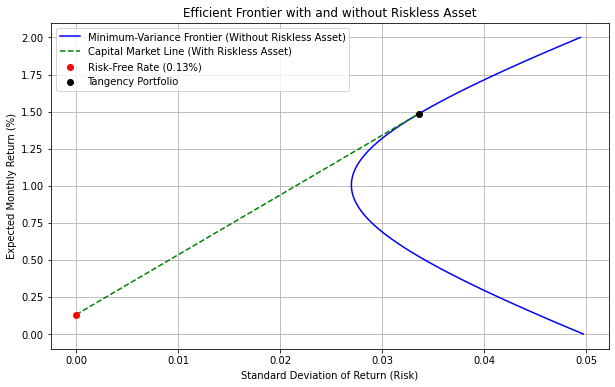

In [10]:
risk_free_rate = 0.0013 

ones = np.ones(len(mean_returns))
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate constants
A = ones.T @ inv_cov_matrix @ ones
B = ones.T @ inv_cov_matrix @ mean_returns
C = mean_returns.T @ inv_cov_matrix @ mean_returns
Delta = A * C - B ** 2

target_returns = np.linspace(0.0, 0.02, 100)

# Calculate portfolio variances
frontier_variances = (A * target_returns ** 2 - 2 * B * target_returns + C) / Delta
frontier_std = np.sqrt(frontier_variances)

# Find the tangency portfolio (portfolio with maximum Sharpe ratio)
tangency_weights = inv_cov_matrix @ (mean_returns - risk_free_rate * ones)
tangency_weights /= ones.T @ inv_cov_matrix @ (mean_returns - risk_free_rate * ones)
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_std = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))

plt.figure(figsize=(10, 6))
plt.plot(frontier_std, target_returns * 100, label='Minimum-Variance Frontier (Without Riskless Asset)', color='blue')

# The CML extends from the risk-free rate through the tangency portfolio
cml_x = np.linspace(0, tangency_std, 100)
cml_y = risk_free_rate + (tangency_return - risk_free_rate) / tangency_std * cml_x
# Plot the CML
plt.plot(cml_x, cml_y * 100, label='Capital Market Line (With Riskless Asset)', color='green', linestyle='--')

# Mark the risk-free rate and tangency portfolio
plt.scatter(0, risk_free_rate * 100, color='red', label='Risk-Free Rate (0.13%)', zorder=5)
plt.scatter(tangency_std, tangency_return * 100, color='black', label='Tangency Portfolio', zorder=5)

plt.xlabel('Standard Deviation of Return (Risk)')
plt.ylabel('Expected Monthly Return (%)')
plt.title('Efficient Frontier with and without Riskless Asset')
plt.grid(True)
plt.legend()
plt.show()

#### Part 3

In [21]:
industry_names = df.columns.tolist()

sharpe_ratio_tangency = (tangency_return - risk_free_rate) / tangency_std

tangency_weights_df = pd.DataFrame({
    'Industry Portfolio': industry_names,
    'Tangency Portfolio Weight': tangency_weights
})

round(tangency_weights_df,3)

,Industry Portfolio,Tangency Portfolio Weight
0,NoDur,0.568
1,Durbl,-0.214
2,Manuf,0.714
3,Enrgy,0.104
4,HiTec,-0.363
5,Telcm,-0.095
6,Shops,0.992
7,Hlth,0.076
8,Utils,0.133
9,Other,-0.913


In [16]:
round(sharpe_ratio_tangency, 3)

0.404